## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [4]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

Using downloaded and verified file: fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz
Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw

Using downloaded and verified file: fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz
Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw

Using downloaded and verified file: fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz
Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [5]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [6]:
len(fmnist_dataset_test)

10000

In [7]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [16]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * 3),
            # nn.BatchNorm1d(input_shape * 3),
            nn.ReLU(),
            nn.Linear(input_shape * 3, input_shape * 3),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(input_shape * 3, input_shape),
            nn.BatchNorm1d(input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [17]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 2352]       1,846,320
              ReLU-3                 [-1, 2352]               0
            Linear-4                 [-1, 2352]       5,534,256
           Dropout-5                 [-1, 2352]               0
              ReLU-6                 [-1, 2352]               0
            Linear-7                  [-1, 784]       1,844,752
       BatchNorm1d-8                  [-1, 784]           1,568
              ReLU-9                  [-1, 784]               0
           Linear-10                   [-1, 10]           7,850
Total params: 9,234,746
Trainable params: 9,234,746
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 35.23
Estima

Your experiments come here:

In [18]:
from IPython import display

from sklearn.metrics import accuracy_score

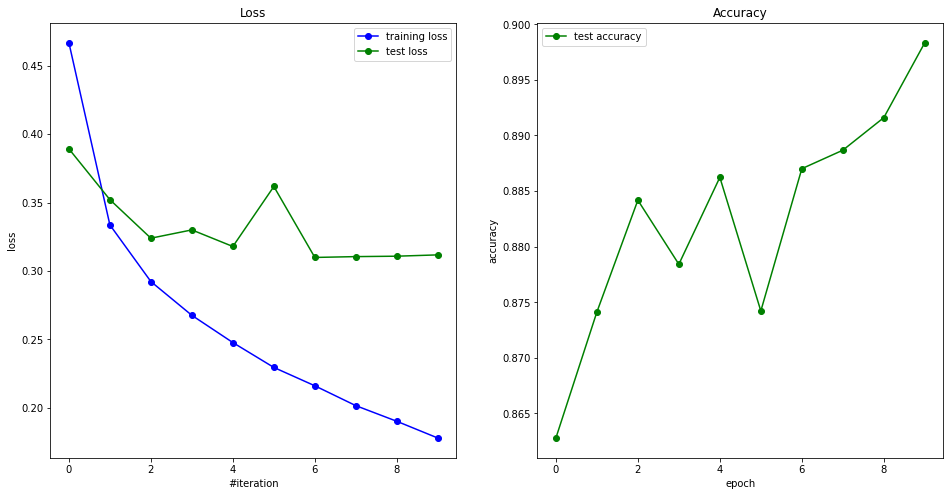

Test accuracy: 0.898


In [19]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, training and validation loops here
train_loss_history = []
test_loss_history = []
test_accuracy_history = []
n_epoch = 10

for i in range(n_epoch):
    # Training loop
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        
        opt.zero_grad()
        
        predictions = model(x_batch.to(device)).cpu()
        loss = loss_func(predictions, y_batch)
        
        loss.backward()      
        
        train_loss += loss.item()

        opt.step()
    train_loss_history.append(train_loss / len(train_loader))

    # Validation loop
    test_accuracy = 0
    test_loss = 0
    model.eval()
    for x_batch, y_batch in test_loader:
        with torch.no_grad():
            predictions = model(x_batch.to(device)).cpu()
            
        loss = loss_func(predictions, y_batch)
        
        test_loss += loss.item()
        test_accuracy += accuracy_score(y_batch, np.argmax(predictions, axis=1))
    test_loss_history.append(test_loss / len(test_loader))
    test_accuracy_history.append(test_accuracy / len(test_loader))

    # Visualize
    if i > 0:
        display.clear_output(wait=True)
        plt.figure(1, figsize=(16, 8))
        
        plt.subplot(121)
        plt.title("Loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(train_loss_history, '-bo', label='training loss')
        plt.plot(test_loss_history, '-go', label='test loss')
        plt.legend()

        plt.subplot(122)
        plt.title("Accuracy")
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.plot(test_accuracy_history, '-go', label='test accuracy')
        plt.legend()
        plt.show()  
    print(f"Test accuracy: {test_accuracy / len(test_loader):.3}")

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [20]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * 2),
            nn.ReLU(),
            nn.Linear(input_shape * 2, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [21]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
              ReLU-3                 [-1, 1568]               0
            Linear-4                  [-1, 784]       1,230,096
              ReLU-5                  [-1, 784]               0
            Linear-6                   [-1, 10]           7,850
Total params: 2,468,826
Trainable params: 2,468,826
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 9.42
Estimated Total Size (MB): 9.46
----------------------------------------------------------------


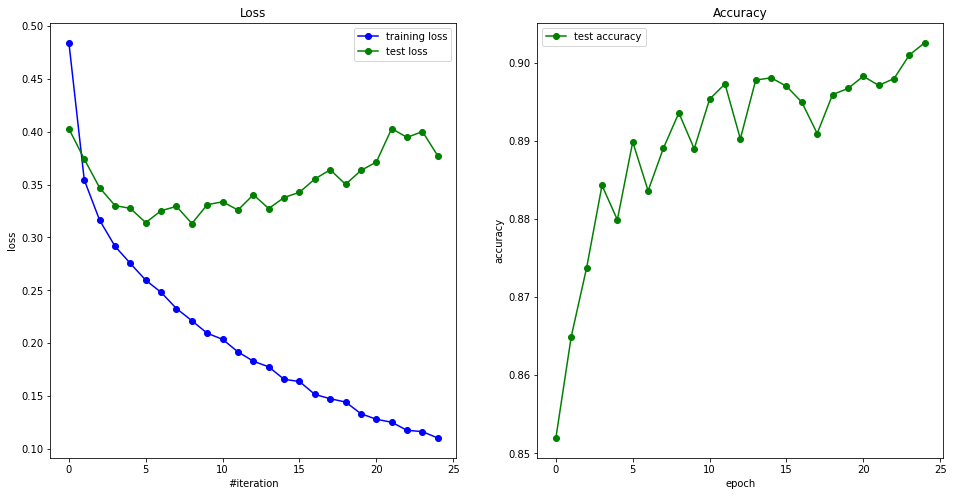

Test accuracy: 0.903


In [22]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters()) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, come here
train_loss_history = []
test_loss_history = []
test_accuracy_history = []
n_epoch = 25

for i in range(n_epoch):
    # Training loop
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        
        opt.zero_grad()
        
        predictions = model(x_batch.to(device)).cpu()
        loss = loss_func(predictions, y_batch)
        
        loss.backward()      
        
        train_loss += loss.item()

        opt.step()
    train_loss_history.append(train_loss / len(train_loader))

    # Validation loop
    test_accuracy = 0
    test_loss = 0
    model.eval()
    for x_batch, y_batch in test_loader:
        with torch.no_grad():
            predictions = model(x_batch.to(device)).cpu()
            
        loss = loss_func(predictions, y_batch)
        
        test_loss += loss.item()
        test_accuracy += accuracy_score(y_batch, np.argmax(predictions, axis=1))
    test_loss_history.append(test_loss / len(test_loader))
    test_accuracy_history.append(test_accuracy / len(test_loader))

    # Visualize
    if i > 0:
        display.clear_output(wait=True)
        plt.figure(1, figsize=(16, 8))
        
        plt.subplot(121)
        plt.title("Loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(train_loss_history, '-bo', label='training loss')
        plt.plot(test_loss_history, '-go', label='test loss')
        plt.legend()

        plt.subplot(122)
        plt.title("Accuracy")
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.plot(test_accuracy_history, '-go', label='test accuracy')
        plt.legend()
        plt.show()  
    print(f"Test accuracy: {test_accuracy / len(test_loader):.3}")

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [23]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * 2),
            nn.BatchNorm1d(input_shape * 2),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(input_shape * 2, input_shape),
            nn.BatchNorm1d(input_shape),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [24]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
       BatchNorm1d-3                 [-1, 1568]           3,136
           Dropout-4                 [-1, 1568]               0
              ReLU-5                 [-1, 1568]               0
            Linear-6                  [-1, 784]       1,230,096
       BatchNorm1d-7                  [-1, 784]           1,568
           Dropout-8                  [-1, 784]               0
              ReLU-9                  [-1, 784]               0
           Linear-10                   [-1, 10]           7,850
Total params: 2,473,530
Trainable params: 2,473,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 9.44
Estimat

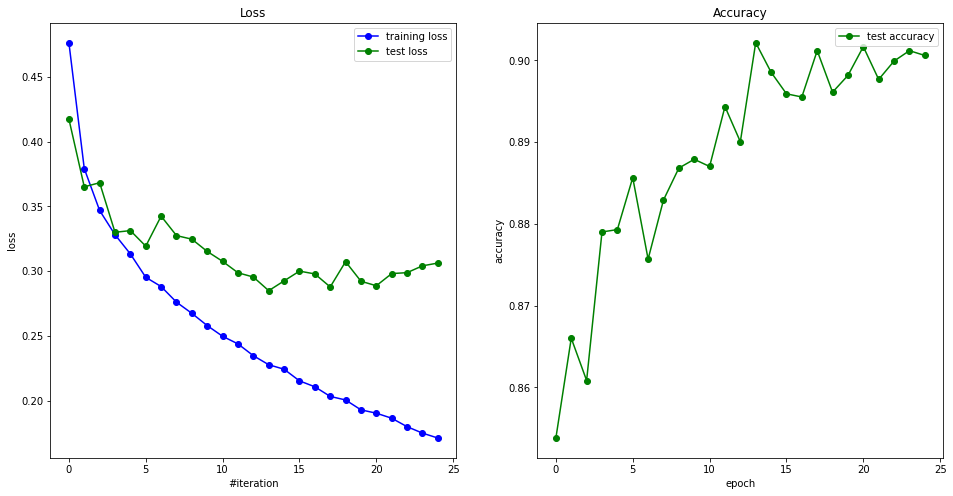

Test accuracy: 0.901


In [25]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters()) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE

# Your experiments, come here
train_loss_history = []
test_loss_history = []
test_accuracy_history = []
n_epoch = 25

for i in range(n_epoch):
    # Training loop
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        
        opt.zero_grad()
        
        predictions = model(x_batch.to(device)).cpu()
        loss = loss_func(predictions, y_batch)
        
        loss.backward()      
        
        train_loss += loss.item()

        opt.step()
    train_loss_history.append(train_loss / len(train_loader))

    # Validation loop
    test_accuracy = 0
    test_loss = 0
    model.eval()
    for x_batch, y_batch in test_loader:
        with torch.no_grad():
            predictions = model(x_batch.to(device)).cpu()
            
        loss = loss_func(predictions, y_batch)
        
        test_loss += loss.item()
        test_accuracy += accuracy_score(y_batch, np.argmax(predictions, axis=1))
    test_loss_history.append(test_loss / len(test_loader))
    test_accuracy_history.append(test_accuracy / len(test_loader))

    # Visualize
    if i > 0:
        display.clear_output(wait=True)
        plt.figure(1, figsize=(16, 8))
        
        plt.subplot(121)
        plt.title("Loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(train_loss_history, '-bo', label='training loss')
        plt.plot(test_loss_history, '-go', label='test loss')
        plt.legend()

        plt.subplot(122)
        plt.title("Accuracy")
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.plot(test_accuracy_history, '-go', label='test accuracy')
        plt.legend()
        plt.show()  
    print(f"Test accuracy: {test_accuracy / len(test_loader):.3}")

### Conclusions:
_Write down small report with your conclusions and your ideas._

Как можно заметить, графика изменения accuracy не достаточно, чтобы увидеть переобучение модели. Loss на валидации начинает расти, но accuracy все еще может увеличиваться. Во 2 задании я решил взять простую сеть с двумя скрытыми слоями, увеличив lr (по сравнению с 1 задачей) и взяв побольше эпох, удалось переобучить модель. Далее, не меняя параметры (lr и количество эпох) и добавив лишь Dropout и BatchNormalization слои, пытался бороться с переобучением. Как видно на графике выше удалось отсрочить начало переобучения примерно на 10 эпох, при этом модель достигает меньшей ошибки на валидации.  